# Dataset generation and use

In [1]:
import random

import matplotlib.pyplot as plt
import matplotlib as mpl

import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, TensorDataset, DataLoader

## Regression data generation

regression data generally should be continuity data
- Data generation
$$y = 2x_1-x_2+1$$

In [2]:
num_inputs = 2
num_examples = 1000

torch.manual_seed(420)

w_true = torch.tensor([2.,-1]).reshape(2,1)
b_true = torch.tensor(1.)

features = torch.randn(num_examples,num_inputs)
labels_true = torch.mm(features, w_true) + b_true
labels = labels_true + torch.randn(size = labels_true.shape) * 0.01

In [4]:
def tensorGenReg(num_examples = 1000, w = [2, -1, 1], bias = True, delta = 0.01, deg = 1):
  
    if bias == True:
        num_inputs = len(w)-1                                                        # 特征张量
        features_true = torch.randn(num_examples, num_inputs)                        # 不包含全是1的列的特征张量
        w_true = torch.tensor(w[:-1]).reshape(-1, 1).float()                         # 自变量系数
        b_true = torch.tensor(w[-1]).float()                                         # 截距
        if num_inputs == 1:                                                          # 若输入特征只有1个，则不能使用矩阵乘法
            labels_true = torch.pow(features_true, deg) * w_true + b_true
        else:
            labels_true = torch.mm(torch.pow(features_true, deg), w_true) + b_true
        features = torch.cat((features_true, torch.ones(len(features_true), 1)), 1)  # 在特征张量的最后添加一列全是1的列
        labels = labels_true + torch.randn(size = labels_true.shape) * delta         
                
    else: 
        num_inputs = len(w)
        features = torch.randn(num_examples, num_inputs)
        w_true = torch.tensor(w).reshape(-1, 1).float()
        if num_inputs == 1:
            labels_true = torch.pow(features, deg) * w_true
        else:
            labels_true = torch.mm(torch.pow(features, deg), w_true)
        labels = labels_true + torch.randn(size = labels_true.shape) * delta
    return features, labels

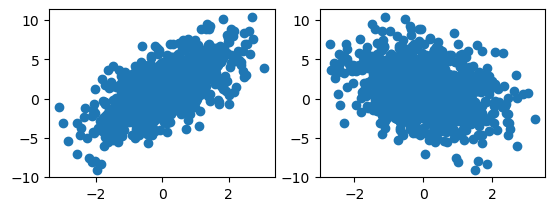

In [5]:
torch.manual_seed(420)   

f, l = tensorGenReg(delta=2)

plt.subplot(223)
plt.scatter(f[:, 0], l)             
plt.subplot(224)
plt.scatter(f[:, 1], l)          

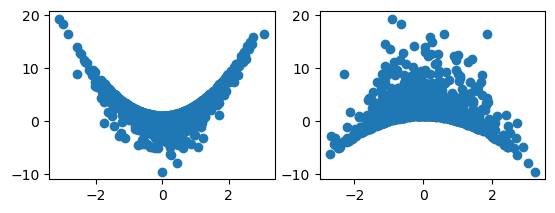

In [6]:

torch.manual_seed(420)   


f, l = tensorGenReg(deg=2)


plt.subplot(223)
plt.scatter(f[:, 0], l)            
plt.subplot(224)
plt.scatter(f[:, 1], l)   

## classes generation

In [7]:
def tensorGenCla(num_examples = 500, num_inputs = 2, num_class = 3, deg_dispersion = [4, 2], bias = False):
    """分类数据集创建函数。
    
    :param num_examples: 每个类别的数据数量
    :param num_inputs: 数据集特征数量
    :param num_class：数据集标签类别总数
    :param deg_dispersion：数据分布离散程度参数，需要输入一个列表，其中第一个参数表示每个类别数组均值的参考、第二个参数表示随机数组标准差。
    :param bias：建立模型逻辑回归模型时是否带入截距
    :return: 生成的特征张量和标签张量，其中特征张量是浮点型二维数组，标签张量是长正型二维数组。
    """
    
    cluster_l = torch.empty(num_examples, 1)                         # 每一类标签张量的形状
    mean_ = deg_dispersion[0]                                        # 每一类特征张量的均值的参考值
    std_ = deg_dispersion[1]                                         # 每一类特征张量的方差
    lf = []                                                          # 用于存储每一类特征张量的列表容器
    ll = []                                                          # 用于存储每一类标签张量的列表容器
    k = mean_ * (num_class-1) / 2                                    # 每一类特征张量均值的惩罚因子（视频中部分是+1，实际应该是-1）
    
    for i in range(num_class):
        data_temp = torch.normal(i*mean_-k, std_, size=(num_examples, num_inputs))     # 生成每一类张量
        lf.append(data_temp)                                                           # 将每一类张量添加到lf中
        labels_temp = torch.full_like(cluster_l, i)                                    # 生成类一类的标签
        ll.append(labels_temp)                                                         # 将每一类标签添加到ll中
        
    features = torch.cat(lf).float()
    labels = torch.cat(ll).long()
    
    if bias == True:
        features = torch.cat((features, torch.ones(len(features), 1)), 1)              # 在特征张量中添加一列全是1的列
    return features, labels

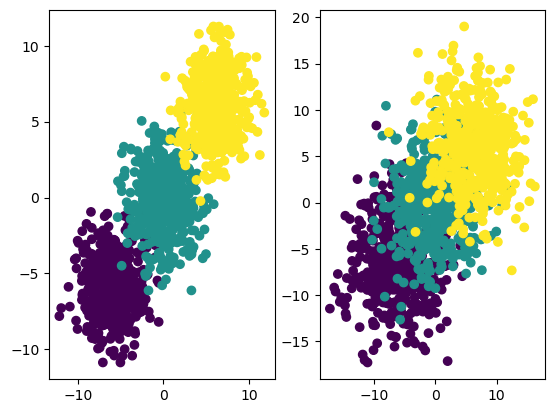

In [12]:
torch.manual_seed(420)

f,l = tensorGenCla(deg_dispersion=[6,2])
f1,l1 = tensorGenCla(deg_dispersion=[6,4])

plt.subplot(121)
plt.scatter(f[:,0],f[:,1],c=l)
plt.subplot(122)
plt.scatter(f1[:,0], f1[:,1],c=l1)

### mini-batch

In [13]:
def data_iter(batch_size, features, labels):
    num_examples = len(features)
    indices = list(range(num_examples))
    random.shuffle(indices)
    l = []
    for i in range(0, num_examples, batch_size):
        j = torch.tensor(indices[i:min(i+batch_size,num_examples)])
        l.append([torch.index_select(features,0,j),torch.index_select(labels,0,j)])
    return l

In [14]:
# test
torch.manual_seed(420)

features, labels = tensorGenCla()
l = data_iter(10,features,labels)

In [15]:
l[0]

[tensor([[ 3.0841, -2.9221],
         [ 3.2704,  5.2172],
         [ 1.2458,  0.0179],
         [ 1.2093, -2.8629],
         [ 2.5576,  3.1783],
         [-1.5385,  0.3029],
         [-5.9867, -7.3293],
         [ 1.6036,  0.5926],
         [-4.1485, -3.9629],
         [ 2.1708,  3.4574]]),
 tensor([[1],
         [2],
         [1],
         [1],
         [2],
         [1],
         [0],
         [1],
         [0],
         [2]])]

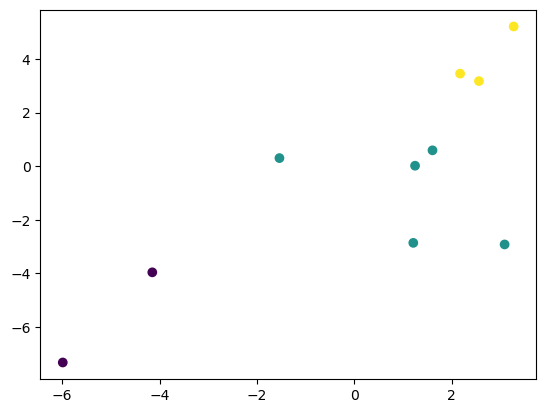

In [16]:
plt.scatter(l[0][0][:, 0], l[0][0][:, 1], c = l[0][1])